# ANN

## AutoGrad

경사하강법을 활용해 오염된 이미지를 복원해보자.  
1. 오염된 이미지와 동일한 크기의 random_tensor를 만든다.  
1. 오염된 이미지를 만든 weird_function에 random_tensor를 입력하고, 그 결과가 오염된 이미지와 같도록 한다.

이로서 weird_function에 대한 이해 없이 이미지를 복원할 수 있다.  
이 과정에서 경사하강법을 사용하는데 이를 pytorch를 사용하지 않고 직접 구현해보자.

In [1]:
import torch
import matplotlib.pyplot as plt
import pickle

- Load image to tensor

torch.Size([10000])


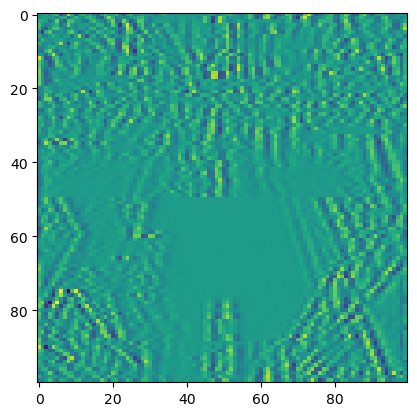

In [10]:
# 오염된 이미지
broken_image = torch.FloatTensor(pickle.load(open('./broken_image_t.p', 'rb'), encoding='latin1'))
print(broken_image.shape)
plt.imshow(broken_image.view(100, 100))
# view : tensor reshape method

In [8]:
# weird_function 정의
def weird_function(x, n_iter=5):
    h = x    
    filt = torch.tensor([-1./3, 1./3, -1./3])
    for i in range(n_iter):
        zero_tensor = torch.tensor([1.0*0])
        h_l = torch.cat( (zero_tensor, h[:-1]), 0)
        h_r = torch.cat((h[1:], zero_tensor), 0 )
        h = filt[0] * h + filt[2] * h_l + filt[1] * h_r
        if i % 2 == 0:
            h = torch.cat( (h[h.shape[0]//2:],h[:h.shape[0]//2]), 0  )
    return h

머신러닝의 강점을 이해하기 위해 위 코드에 대한 이해 없이 진행해보겠다.

In [9]:
# hypotesis와 broken_image 사이의 오차
def distance_loss(hypothesis, broken_image):
    return torch.dist(hypothesis, broken_image)

In [11]:
# random_tensor 정의
random_tensor = torch.randn(10000, dtype=torch.float)

PyTorch의 도움을 배제하고 직접 최적화 알고리즘을 구현해보자.

Loss at 0 = 12.329081535339355
Loss at 1000 = 1.1847604513168335
Loss at 2000 = 0.5621352791786194
Loss at 3000 = 0.3859546184539795
Loss at 4000 = 0.30331769585609436
Loss at 5000 = 0.2534330487251282
Loss at 6000 = 0.21837787330150604
Loss at 7000 = 0.19099605083465576
Loss at 8000 = 0.16798906028270721
Loss at 9000 = 0.1476784348487854
Loss at 10000 = 0.12913250923156738
Loss at 11000 = 0.11179708689451218
Loss at 12000 = 0.09532545506954193
Loss at 13000 = 0.07949304580688477
Loss at 14000 = 0.0641506239771843
Loss at 15000 = 0.04919740557670593
Loss at 16000 = 0.03456496819853783
Loss at 17000 = 0.020209284499287605
Loss at 18000 = 0.02116367034614086
Loss at 19000 = 0.021166794002056122


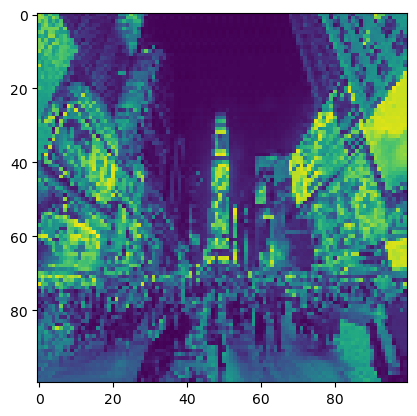

In [13]:
# 학습률
lr = 0.8

# 경사하강법 정의
for i in range(20000):
    random_tensor.requires_grad_(True)
    hypothesis = weird_function(random_tensor)
    loss = distance_loss(hypothesis, broken_image)
    loss.backward() # pytorch에서 제공하는 자동 미분을 직접 구현.
    with torch.no_grad():
        random_tensor = random_tensor - lr * random_tensor.grad
    if i % 1000 == 0:
        print('Loss at {} = {}'.format(i, loss.item()))
plt.imshow(random_tensor.view(100, 100).data)

# ANN 구현

> - dataset 소개  
> make_blobs dataset : 각 data가 몇번째 cluster에 속하는지 알려주는 data

In [15]:
# import libraries
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import numpy

### Prepare Dataset

In [29]:
# datasets
n_dim = 2
x_train, y_train = make_blobs(n_samples = 80, n_features=n_dim,
                             centers=[[1,1], [-1,-1], [1, -1], [-1,1]],
                             shuffle=True, cluster_std=0.3)

x_test, y_test = make_blobs(n_samples=20, n_features=n_dim,
                           centers=[[1,1], [-1,-1], [1, -1], [-1,1]],
                             shuffle=True, cluster_std=0.3)

In [30]:
# 2개 label을 예측하는 모델을 만들기 위해 4개 label을 2개로 합쳐보자.
# label 0,1 -> 0
# label 2,3 -> 1
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

# 예측값이 [0,1]에 있는 경우 0으로 mapping
# 예측값이 [2,3]에 있는 경우 1로 mapping
y_train = label_map(y_train, [0,1], 0)
y_train = label_map(y_train, [2,3], 1)
y_test = label_map(y_test, [0,1], 0)
y_test = label_map(y_test, [2,3], 1)

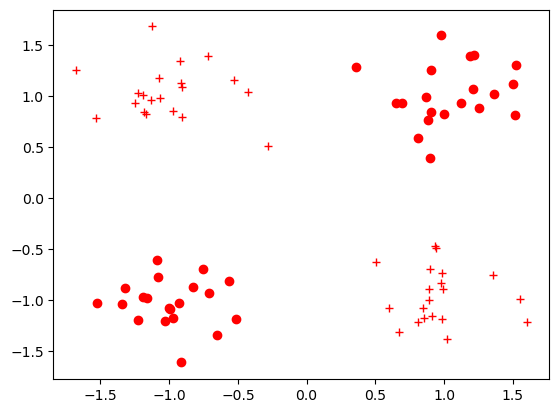

In [31]:
# 시각화
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.show()

In [32]:
# convert datasets to tensor
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

### Model Construction

In [33]:
class NeuralNet(torch.nn.Module):
    # 생성자
    # input_size: 신경망에 입력되는 데이터 차원
    
    def __init__(self, input_size, hidden_size):
        # nn.Module 속성을 통해 초기화
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # ANN에서 진행될 연산
        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size) # [1, hidden_size] shape의 tensor 반환
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(self.hidden_size, 1) # [1,1]
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input_tensor):
        linear1 = self.linear_1(input_tensor)
        relu = self.relu(linear1)
        linear2 = self.linear_2(relu)
        output = self.sigmoid(linear2)
        return output

In [34]:
model = NeuralNet(2, 5) # input_size = 2, hidden_size = 5

learning_rate = 0.03 # 학습률
criterion = torch.nn.BCELoss() # 오차함수 - Binary Cross Entropy

epochs = 2000 # 학습 횟수

In [35]:
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

### Evaluation Before training

In [36]:
# 학습 진행 전 모델 평가
model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test) # squeeze()를 통한 차원 일치
print('Before Training, test loss is {}'.format(test_loss_before.item())) # item() : tensor를 스칼라로 변환

Before Training, test loss is 0.730697512626648


Terrible : 100번 중 73번은 틀린다.

### Train model

In [37]:
for epoch in range(epochs):
    model.train() # train mode
    optimizer.zero_grad() # 매 epoch마다 grad = 0으로 초기화
    
    train_output = model(x_train)
    
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
    
    # 역전파   
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.7306373715400696
Train loss at 100 is 0.6939905285835266
Train loss at 200 is 0.6711951494216919
Train loss at 300 is 0.6338726878166199
Train loss at 400 is 0.5803431272506714
Train loss at 500 is 0.526516318321228
Train loss at 600 is 0.4631578326225281
Train loss at 700 is 0.38928380608558655
Train loss at 800 is 0.3096694350242615
Train loss at 900 is 0.23798684775829315
Train loss at 1000 is 0.18360891938209534
Train loss at 1100 is 0.14613763988018036
Train loss at 1200 is 0.11944343894720078
Train loss at 1300 is 0.09994588792324066
Train loss at 1400 is 0.0853056013584137
Train loss at 1500 is 0.07405836880207062
Train loss at 1600 is 0.0652027502655983
Train loss at 1700 is 0.05807270482182503
Train loss at 1800 is 0.052240271121263504
Train loss at 1900 is 0.04740014299750328


### Evaluation After Trainning

In [38]:
model.eval()
test_loss = criterion(torch.squeeze(model(x_test)), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.042288489639759064


모델의 오차가 현저히 줄어듦을 확인할 수 있다.

### 모델 저장
>- state_dict()  
>모델 저장과 더불어 가중치들이 딕셔너리 형태로 저장됨

저장된 모델은 언제든 불러와 학습된 가중치를 적용할 수 있다.

In [39]:
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[-1.3771, -1.4477],
        [ 0.7682,  0.7507],
        [-0.1512, -0.3004],
        [ 2.2611,  2.1898],
        [ 0.2147,  0.2222]])), ('linear_1.bias', tensor([-0.0662,  1.8186,  0.2405, -0.3845, -0.3024])), ('linear_2.weight', tensor([[-1.8584,  2.0184, -0.2233, -3.0172, -0.0505]])), ('linear_2.bias', tensor([0.6971]))])


In [40]:
# 저장된 모델 불러오기
new_model = NeuralNet(2,5)
new_model.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

In [41]:
new_model.eval()
print('벡터 [-1, 1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1, 1])).item()))

벡터 [-1, 1]이 레이블 1을 가질 확률은 0.9867740869522095
